### Импортируем библиотеки
### WARNING: для отправки сообщений используется python-telegram-bot=13.7

In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import telegram
import io
import scipy.stats as stats

### Задаем значения переменным

In [2]:
token = BOT_TOKEN
bot = telegram.Bot(token=token)
chat_id = 96083455
group_chat_id = -958942131 # alert group chat

In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20230320',
    'user':'student', 
    'password':'dpo_python_2020'
}

### В запросе округляем время везде до 15 минут, чтобы рендж 15-тиминуток был суточным

In [4]:
query = '''
SELECT toStartOfFifteenMinutes(time) AS timestamp,
      count(distinct user_id) as dau,
      countIf(user_id, action='like') as likes,
      countIf(user_id, action='view') as views,
      round(countIf(user_id, action='like') / countIf(user_id, action='view'), 3) AS ctr
FROM simulator_20230320.feed_actions
WHERE time >= toStartOfFifteenMinutes(now()) - INTERVAL '1 DAY'
  AND time < toStartOfFifteenMinutes(now())
GROUP BY toStartOfFifteenMinutes(time)
ORDER BY timestamp
'''

In [5]:
df = ph.read_clickhouse(query, connection=connection)
df.tail(10)

,timestamp,dau,likes,views,ctr
86,2023-04-24 08:30:00,491,1457,6514,0.224
87,2023-04-24 08:45:00,517,1348,6612,0.204
88,2023-04-24 09:00:00,576,1658,7409,0.224
89,2023-04-24 09:15:00,553,1604,7390,0.217
90,2023-04-24 09:30:00,580,1661,7798,0.213
91,2023-04-24 09:45:00,577,1674,7825,0.214
92,2023-04-24 10:00:00,589,1584,7316,0.217
93,2023-04-24 10:15:00,612,1684,7720,0.218
94,2023-04-24 10:30:00,607,1605,7523,0.213
95,2023-04-24 10:45:00,602,1630,7643,0.213


### Смотрим на распределение метрики, определяем среднее и стандартное отклонение

<AxesSubplot:>

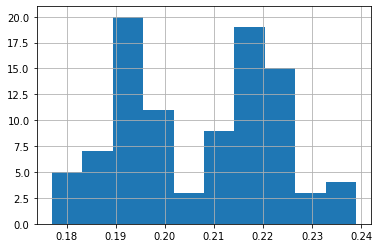

In [6]:
df.ctr.hist()

In [7]:
df.ctr.std()

0.015432706212865958

In [8]:
df.ctr.mean()

0.207

### Проверяем формулу отклонения метрики в %

In [9]:
round((df.iloc[-1, 4] - df.ctr.mean()) / df.ctr.mean() * 100, 2)

2.9

### Тестируем код для создания чарта и отправки его в Телеграм

In [11]:
plt.rcParams['figure.figsize'] = [20, 12]
sns.set()
plot_object = io.BytesIO()
ax = sns.lineplot(data=df, x='timestamp', y='ctr', marker='o')
ax.set(title='CTR за последние 24 часа')
plt.savefig(plot_object)
plot_object.seek(0)
plt.close()
bot.sendPhoto(chat_id=chat_id, photo=plot_object)

[Text(0.5, 1.0, 'CTR за последние 24 часа')]

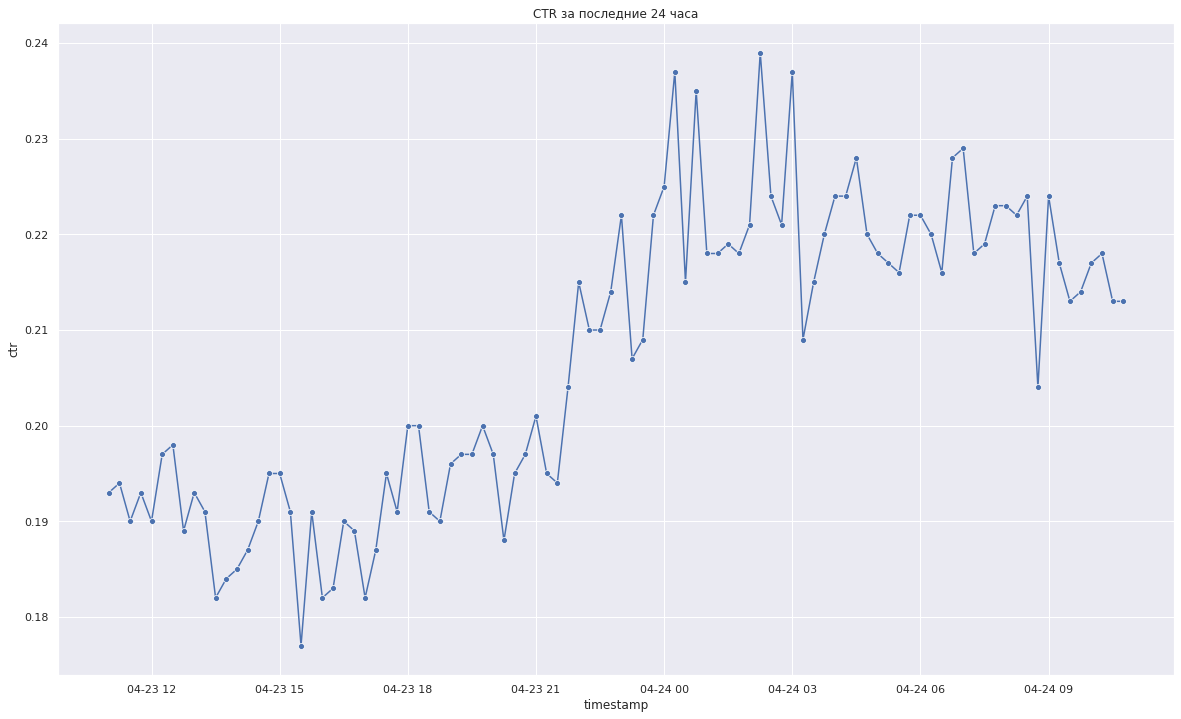

In [12]:
ax = sns.lineplot(data=df, x='timestamp', y='ctr', marker='o')
ax.set(title='CTR за последние 24 часа')

### Пишем код для проверки каждой метрики и отправки сообщения в Телеграм при отклонении более 3 сигм в любую сторону

In [13]:
plt.rcParams['figure.figsize'] = [20, 12]
sns.set()

In [14]:
if (df.iloc[-1, 4]) > df.ctr.mean() + 3*df.ctr.std() or (df.iloc[-1, 4]) < df.ctr.mean() - 3*df.ctr.std():
    bot.sendMessage(chat_id=group_chat_id, text=f'''Метрика CTR в ленте новостей. 
    Текущее значение {df.iloc[-1, 4]}. Отклонение более {round((df.iloc[-1, 4] - df.ctr.mean()) / df.ctr.mean() * 100, 2)}%.
    Дашборд: https://superset.lab.karpov.courses/superset/dashboard/3184/''')
    plot_object = io.BytesIO()
    ax = sns.lineplot(data=df, x='timestamp', y='ctr', marker='o')
    ax.set(title='CTR за последние 24 часа')
    plt.savefig(plot_object)
    plot_object.seek(0)
    plt.close()
    bot.sendPhoto(chat_id=group_chat_id, photo=plot_object)

In [15]:
if (df.iloc[-1, 1]) > df.dau.mean() + 3*df.dau.std() or (df.iloc[-1, 1]) < df.dau.mean() - 3*df.dau.std():
    bot.sendMessage(chat_id=group_chat_id, text=f'''Метрика DAU в ленте новостей. 
    Текущее значение {df.iloc[-1, 1]}. Отклонение более {round((df.iloc[-1, 1] - df.dau.mean()) / df.dau.mean() * 100, 2)}%.
    Дашборд: https://superset.lab.karpov.courses/superset/dashboard/3184/''')
    plot_object = io.BytesIO()
    ax = sns.lineplot(data=df, x='timestamp', y='dau', marker='o')
    ax.set(title='DAU за последние 24 часа')
    plt.savefig(plot_object)
    plot_object.seek(0)
    plt.close()
    bot.sendPhoto(chat_id=group_chat_id, photo=plot_object)

In [16]:
if (df.iloc[-1, 2]) > df.likes.mean() + 3*df.likes.std() or (df.iloc[-1, 2]) < df.likes.mean() - 3*df.likes.std():
    bot.sendMessage(chat_id=group_chat_id, text=f'''Метрика LIKES в ленте новостей. 
    Текущее значение {df.iloc[-1, 2]}. Отклонение более {round((df.iloc[-1, 2] - df.likes.mean()) / df.likes.mean() * 100, 2)}%.
    Дашборд: https://superset.lab.karpov.courses/superset/dashboard/3184/''')
    plot_object = io.BytesIO()
    ax = sns.lineplot(data=df, x='timestamp', y='likes', marker='o')
    ax.set(title='Лайки за последние 24 часа')
    plt.savefig(plot_object)
    plot_object.seek(0)
    plt.close()
    bot.sendPhoto(chat_id=group_chat_id, photo=plot_object)

In [17]:
if (df.iloc[-1, 3]) > df.views.mean() + 3*df.views.std() or (df.iloc[-1, 3]) < df.views.mean() - 3*df.views.std():
    bot.sendMessage(chat_id=group_chat_id, text=f'''Метрика VIEWS в ленте новостей. 
    Текущее значение {df.iloc[-1, 3]}. Отклонение более {round((df.iloc[-1, 3] - df.views.mean()) / df.views.mean() * 100, 2)}%.
    Дашборд: https://superset.lab.karpov.courses/superset/dashboard/3184/''')
    plot_object = io.BytesIO()
    ax = sns.lineplot(data=df, x='timestamp', y='views', marker='o')
    ax.set(title='Просмотры за последние 24 часа')
    plt.savefig(plot_object)
    plot_object.seek(0)
    plt.close()
    bot.sendPhoto(chat_id=group_chat_id, photo=plot_object)

### Выбираем данные для другой таблицы (мессенджер) и обрабатываем их

In [18]:
query = '''
SELECT toStartOfFifteenMinutes(time) AS timestamp,
      count(distinct user_id) as dau,
      count(user_id) as messages_sent
FROM simulator_20230320.message_actions 
WHERE time >= toStartOfFifteenMinutes(now()) - INTERVAL '1 DAY'
  AND time < toStartOfFifteenMinutes(now())
GROUP BY toStartOfFifteenMinutes(time)
ORDER BY timestamp
'''

In [19]:
df = ph.read_clickhouse(query, connection=connection)
df.tail(10)

,timestamp,dau,messages_sent
86,2023-04-24 08:30:00,87,109
87,2023-04-24 08:45:00,105,119
88,2023-04-24 09:00:00,116,148
89,2023-04-24 09:15:00,114,144
90,2023-04-24 09:30:00,109,138
91,2023-04-24 09:45:00,123,149
92,2023-04-24 10:00:00,138,191
93,2023-04-24 10:15:00,122,155
94,2023-04-24 10:30:00,132,178
95,2023-04-24 10:45:00,144,172


<AxesSubplot:>

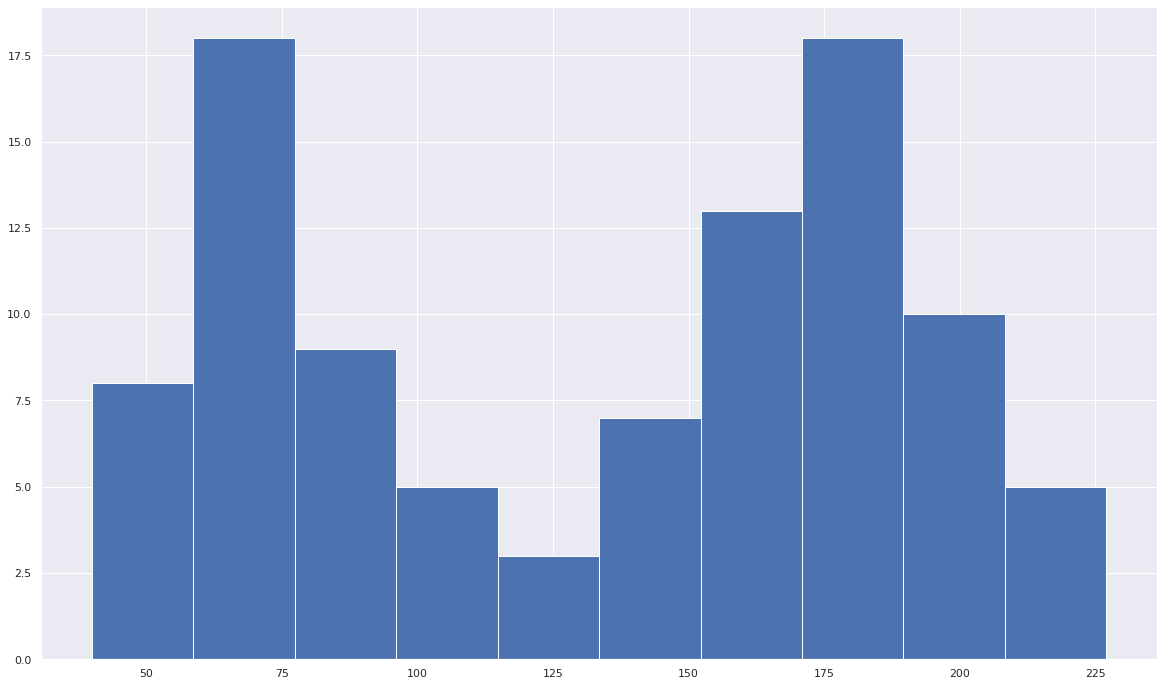

In [20]:
df.messages_sent.hist()

In [21]:
plt.rcParams['figure.figsize'] = [20, 12]
sns.set()

In [22]:
if (df.iloc[-1, 1]) > df.dau.mean() + 3*df.dau.std() or (df.iloc[-1, 1]) < df.dau.mean() - 3*df.dau.std():
    bot.sendMessage(chat_id=group_chat_id, text=f'''Метрика DAU в ленте новостей. 
    Текущее значение {df.iloc[-1, 1]}. Отклонение более {round((df.iloc[-1, 1] - df.dau.mean()) / df.dau.mean() * 100, 2)}%.
    ''')
    plot_object = io.BytesIO()
    ax = sns.lineplot(data=df, x='timestamp', y='dau', marker='o')
    ax.set(title='DAU за последние 24 часа')
    plt.savefig(plot_object)
    plot_object.seek(0)
    plt.close()
    bot.sendPhoto(chat_id=group_chat_id, photo=plot_object)

In [23]:
if (df.iloc[-1, 2]) > df.messages_sent.mean() + 3*df.messages_sent.std() or (df.iloc[-1, 2]) < df.messages_sent.mean() - 3*df.messages_sent.std():
    bot.sendMessage(chat_id=group_chat_id, text=f'''Метрика Отправленные сообщения в ленте новостей. 
    Текущее значение {df.iloc[-1, 2]}. Отклонение более {round((df.iloc[-1, 2] - df.messages_sent.mean()) / df.messages_sent.mean() * 100, 2)}%.
    ''')
    plot_object = io.BytesIO()
    ax = sns.lineplot(data=df, x='timestamp', y='dau', marker='o')
    ax.set(title='DAU за последние 24 часа')
    plt.savefig(plot_object)
    plot_object.seek(0)
    plt.close()
    bot.sendPhoto(chat_id=group_chat_id, photo=plot_object)